In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

## Integrals

In [2]:
def H_0(p, q):
    """
    The one body part of the hamiltonian
    
    delta = 1
    """
    if p == q:
        p1, s2 = states[p]
        return p1 - 1
    else:
        return 0

In [3]:
def sp_energy(h, u):
    SP_energy = np.zeros(l)
    for q in range(l):
        SP_energy[q] = h[q, q]
        for i in range(n):
            SP_energy[q] += u[q, i, q, i]
    return SP_energy

In [4]:
def V(p,q,r,s,g):
    p1, s1 = states[p]
    p2, s2 = states[q]
    p3, s3 = states[r]
    p4, s4 = states[s]

    if p1 != p2 or p3 != p4:
        return 0
    if s1 == s2 or s3 == s4:
        return 0
    if s1 == s3 and s2 == s4:
        return -g/2
    if s1 == s4 and s2 == s3:
        return g/2

In [5]:
def get_integrals(g):
    h = np.zeros((l, l))
    u = np.zeros((l, l, l, l))

    for p in range(l):
        for q in range(l):
            h[p, q] = H_0(p, q)

            for r in range(l):
                for s in range(l):
                    u[p, q, r, s] = V(p, q, r, s, g)

    SP_energy = sp_energy(h, u)        
                    
    return h, u, SP_energy

In [7]:
n = 4
l = 8

#        [(1, 1), (1, -1), (2, 1), (2, -1), (3, 1), (3, -1), (4, 1), (4, -1)]
states = [(p//2 + 1, 1 if p%2==0 else -1) for p in range(l)]

g_arr = np.linspace(-1, 1, 100)

In [8]:
g = 1
h, u, SP_energy = get_integrals(g)

## CCD Init and Energy

In [9]:
def init_CCD(u, SP_energy):
    t = np.zeros((l, l, l, l))
    for i in range(n):
        for j in range(n):
            for a in range(n, l):
                for b in range(n, l):
                    t[a, b, i, j] = u[a, b, i, j] / (SP_energy[i] + SP_energy[j] - SP_energy[a] - SP_energy[b])
    return t

In [10]:
def E_CCD(t, u):
    e_tot = 0
    for i in range(n):
        for j in range(n):
            for a in range(n, l):
                for b in range(n, l):
                    e_tot += u[i, j, a, b] * t[a, b, i, j]
    return 0.25 * e_tot

In [11]:
def MBPT2_e(u, SP_energy):
    e = 0
    for i in range(n):
        for j in range(n):
            for a in range(n, l):
                for b in range(n, l):
                    e += u[i, j, a, b] * u[a, b, i, j] / (SP_energy[i] + SP_energy[j] - SP_energy[a] - SP_energy[b])
    return 0.25 * e

In [13]:
ga = np.linspace(-1,1,20)
mbpt2 = [-0.466666666666667, -0.349182847035464, -0.255689278272465, -0.181557193313316, -0.123412048501471, -0.0787163482561267, -0.0455115650210057, -0.0222520908928102, -0.00769472737749595, -0.000822937515997602, -0.000793561891960060, -0.00689846543830067, -0.0185363596456308, -0.0351917165544882, -0.0564187262319234, -0.0818289072434782, -0.111081407376344, -0.143875315926770, -0.179943501160728, -0.219047619047619]
mbpt3 = [0.0488888888888889, -0.0316430818998829, -0.0653314223276869, -0.0721092071206414, -0.0642577496533054, -0.0495666500220538, -0.0330827101356087, -0.0181217847556307, -0.00687677135187049, -0.000795029103693348, -0.000819381146390719, -0.00754584419303519, -0.0213291046738017, -0.0423543929354630, -0.0706872722072964, -0.106308625103258, -0.149139543216922, -0.199059220049532, -0.255917926398189, -0.319546485260771]
exact = [-0.22012986, -0.18119196, -0.14512971, -0.11221238, -0.08274543, -0.05707431, -0.03558758, -0.01871907, -0.00694793, -0.00079584, -0.00082013, -0.00760173, -0.02172721, -0.04376486, -0.07423605, -0.11358437, -0.16214629, -0.22012784, -0.2875909 , -0.36445153]


In [126]:
ccd_init = np.zeros(20)
for i in range(20):
    g = ga[i]
    h, u, SP_energy = get_integrals(g)
    t = init_CCD(u, SP_energy)
    e = E_CCD(t, u)
    ccd_init[i] = e

In [154]:
def analytical(g):
    return -g**2 / 4 * ( 1 / (4+g) + 1/(6+g) + 1/(2+g) + 1/(4+g) )

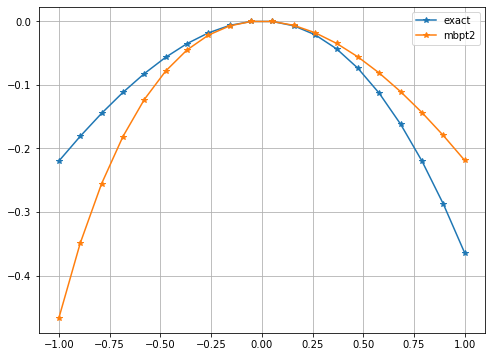

In [159]:
plt.figure(figsize = (8, 6))
plt.plot(ga, exact, "-*", label="exact")
#plt.plot(ga, mbpt3, "-*", label="mbpt3")
plt.plot(ga, analytical(ga), "-*", label="mbpt2")
#plt.plot(ga, mbpt2, "-*", label="mbpt2")
#plt.plot(ga, ccd_init, "-*", label="ccd_init")
#plt.plot(ga, ccd_es, "-*", label="ccd_es")

plt.grid()
plt.legend()
plt.show()

## CCD Update

In [152]:
ccd_es = np.zeros(20)
for i in range(20):
    g = ga[i]
    h, u, SP_energy = get_integrals(g)
    t = init_CCD(u, SP_energy)
    
    for j in range(10):
        t = CCD_Update(t, u, SP_energy)
    
    e = E_CCD(t, u)
    ccd_es[i] = e

In [135]:
g = ga[1]
h, u, SP_energy = get_integrals(g)
t = init_CCD(u, SP_energy)

In [136]:
mbpt2[1]

-0.349182847035464

In [137]:
E_CCD(t, u)

-0.3491828470354639

In [138]:
t = CCD_Update(t, u, SP_energy)
E_CCD(t_old, u)

-0.1803062264968051

In [139]:
alpha = 0.5

In [151]:
%%time
t = CCD_Update(t, u, SP_energy)

Wall time: 45.5 ms


In [148]:
def CCD_Update(t_old, u, SP_energy):
    t_new = np.zeros((l, l, l, l))
    for i in range(n):
        for j in range(i+1, n):
            for a in range(n, l):
                for b in range(a+1, l):
                    # Page 361 of An Advanced Course in Computational Physics
                    s = 0

                    s += u[a, b, i, j]

                    for c in range(n, l):
                        for d in range(n, l):
                            s += 0.5 * u[a, b, c, d] * t_old[c, d, i, j]

                    for k in range(n):
                        for li in range(n):
                            s += 0.5 * u[k, li, i, j] * t_old[a, b, k, li]

                    for k in range(n):
                        for c in range(n, l):
                            s += u[k, b, c, j] * t_old[a, c, i, k] # 1
                            s -= u[k, b, c, i] * t_old[a, c, j, k] # -Pij
                            s -= u[k, a, c, j] * t_old[b, c, i, k] # -Pab
                            s += u[k, a, c, i] * t_old[b, c, j, k] # Pij Pab

                    for k in range(n):
                        for li in range(n):
                            for c in range(n, l):
                                for d in range(n, l):
                                    s += 0.25 * u[k, li, c, d] * t_old[c, d, i, j] * t_old[a, b, k, li]

                                    s += u[k, li, c, d] * t_old[a, c, i, k] * t_old[b, d, j, li] # 1
                                    s -= u[k, li, c, d] * t_old[a, c, j, k] * t_old[b, d, i, li] # -Pij

                                    s -= 0.5 * u[k, li, c, d] * t_old[d, c, i, k] * t_old[a, b, li, j] # -1
                                    s += 0.5 * u[k, li, c, d] * t_old[d, c, j, k] * t_old[a, b, li, i] # Pij

                                    s -= 0.5 * u[k, li, c, d] * t_old[a, c, li, k] * t_old[d, b, i, j] # -1
                                    s += 0.5 * u[k, li, c, d] * t_old[b, c, li, k] * t_old[d, a, i, j] # Pab

                    energy_denom = SP_energy[i] + SP_energy[j] - SP_energy[a] - SP_energy[b]
                    s = alpha * t_old[a, b, i, j] + (1- alpha) * s / energy_denom
                    t_new[a, b, i, j] = s
                    t_new[a, b, j, i] = -s
                    t_new[b, a, i, j] = -s
                    t_new[b, a, j, i] = s
    return t_new

In [162]:
def CCD_Update_Slow(t_old, u, SP_energy):
    t_new = np.zeros((l, l, l, l))
    for i in range(n):
        for j in range(n):
            for a in range(n, l):
                for b in range(n, l):
                    # Page 361 of An Advanced Course in Computational Physics
                    s = 0

                    s += u[a, b, i, j]

                    for c in range(n, l):
                        for d in range(n, l):
                            s += 0.5 * u[a, b, c, d] * t_old[c, d, i, j]

                    for k in range(n):
                        for li in range(n):
                            s += 0.5 * u[k, li, i, j] * t_old[a, b, k, li]

                    for k in range(n):
                        for c in range(n, l):
                            s += u[k, b, c, j] * t_old[a, c, i, k] # 1
                            s -= u[k, b, c, i] * t_old[a, c, j, k] # -Pij
                            s -= u[k, a, c, j] * t_old[b, c, i, k] # -Pab
                            s += u[k, a, c, i] * t_old[b, c, j, k] # Pij Pab

                    for k in range(n):
                        for li in range(n):
                            for c in range(n, l):
                                for d in range(n, l):
                                    s += 0.25 * u[k, li, c, d] * t_old[c, d, i, j] * t_old[a, b, k, li]

                                    s += u[k, li, c, d] * t_old[a, c, i, k] * t_old[b, d, j, li] # 1
                                    s -= u[k, li, c, d] * t_old[a, c, j, k] * t_old[b, d, i, li] # -Pij

                                    s -= 0.5 * u[k, li, c, d] * t_old[d, c, i, k] * t_old[a, b, li, j] # -1
                                    s += 0.5 * u[k, li, c, d] * t_old[d, c, j, k] * t_old[a, b, li, i] # Pij

                                    s -= 0.5 * u[k, li, c, d] * t_old[a, c, li, k] * t_old[d, b, i, j] # -1
                                    s += 0.5 * u[k, li, c, d] * t_old[b, c, li, k] * t_old[d, a, i, j] # Pab

                    energy_denom = SP_energy[i] + SP_energy[j] - SP_energy[a] - SP_energy[b]
                    s = alpha * t_old[a, b, i, j] + (1- alpha) * s / energy_denom
                    t_new[a, b, i, j] = s
    return t_new

In [182]:
g = ga[1] # -0.8947368421052632
h, u, SP_energy = get_integrals(g)
t_initial = init_CCD(u, SP_energy)
t_fast = CCD_Update(t_initial, u, SP_energy)
t_slow = CCD_Update_Slow(t_initial, u, SP_energy)

In [201]:
%%time
t_fast = CCD_Update(t_fast, u, SP_energy)

Wall time: 40.9 ms


In [199]:
%%time
t_slow = CCD_Update_Slow(t_slow, u, SP_energy)

Wall time: 297 ms


In [185]:
print(np.amin(t_fast - t_initial), np.amax(t_fast - t_initial))

-0.23032424989143802 0.23032424989143802


In [198]:
print(np.amin(t_fast - t_slow), np.amax(t_fast - t_slow))

0.0 0.0
